In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import pickle

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(0)

In [0]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [0]:
os.chdir('/content/data/My Drive/DL_Assignment_2')

In [0]:
###### Data import #############
'''mapping = {'coast':0,'forest':1,'insidecity':2,'mountain':3,'street':4}

X = []
Y = []
for folder, label in zip(mapping.keys(), mapping.values()):
  folder_path = os.path.join('./Data_1', folder)
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      f = open(file_path, 'r')
      x = f.read().split()
      X.append([float(i) for i in x])
      Y.append(label)
      

with open("Data_1_X.pkl", "wb") as pickle_out:
    pickle.dump(X, pickle_out) 

with open("Data_1_Y.pkl", "wb") as pickle_out:
    pickle.dump(Y, pickle_out) '''
    

In [0]:
with open("./Data_1_X.pkl", "rb") as pickle_out:
    X = pickle.load(pickle_out) 

with open("./Data_1_Y.pkl", "rb") as pickle_out:
    Y = pickle.load(pickle_out)


In [0]:
X = np.array(X, np.float)
Y = np.array(Y, np.float)

#train,test splt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [0]:
#### Auto Encoder  #############

class AutoEncoder(nn.Module):
    def __init__(self, D_in, NL, L):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(D_in, NL),
            nn.Sigmoid(),
            nn.Linear(NL, L),
        )
        self.decoder = nn.Sequential(
            nn.Linear(L, NL),
            nn.Sigmoid(),
            nn.Linear(NL, D_in),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def AutoEncoderModel(x, input_size, hidden_size, bottle_neck_size):
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64
  
  print("bottle_neck_size : ",bottle_neck_size)
  print('***********************************')
  x_torch = torch.tensor(x); 
  x_torch = x_torch.to(device)
  

  D_in = input_size
  NL = hidden_size
  L = bottle_neck_size
  MAX_EPOCH = 1000
  BATCH_SIZE = 128
  LR = 1e-4        
  ERROR_THRESHOLD = 1e-6

  train_loader = torch.utils.data.DataLoader(x_torch, batch_size = BATCH_SIZE, shuffle=False)


  AE = AutoEncoder(D_in, NL, L)
  AE = AE.to(device)
  optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
  loss_fn = torch.nn.MSELoss(reduction='mean')
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader:  

        encoded, decoded = AE(data)

        loss = loss_fn(decoded, data)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  
       
      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 100 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-4] - error_train[epoch]) <= ERROR_THRESHOLD:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.title('MSE vs epochs')
  plt.show()
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('reconstruction error: ', error_train[-1])
  print('***********************************')
  print('***********************************')
  
  x_ae, _ = AE(x_torch)
  x_ae = x_ae.cpu().detach()
  
  
  return AE,x_ae

In [0]:
def Stacked_AE_Models(x_train,bottle_neck_size):
  
  D_in = x_train.shape[1]
  
  D_in_1 = D_in
  D_in_2 = bottle_neck_size
  D_in_3 = int((D_in_2)*0.7*0.7)
  
  AE1, feat1 = AutoEncoderModel(x_train, D_in_1, int(D_in_1*0.7), bottle_neck_size)
  AE2, feat2 = AutoEncoderModel(feat1, D_in_2, int(D_in_2*0.7), D_in_3)
  AE3, feat3 = AutoEncoderModel(feat2, D_in_3, int(D_in_3*0.7), int(D_in_3*0.7*0.7))
  
  
  
  return AE1,AE2,AE3,feat3, int(D_in_3*0.7*0.7) 

def Stacked_AEs(bottle_neck_size):
  
  D_in = 828
  
  D_in_1 = D_in
  D_in_2 = bottle_neck_size
  D_in_3 = int((D_in_2)*0.7*0.7)
  
  AE1 = AutoEncoder(D_in_1, int(D_in_1*0.7), bottle_neck_size)
  AE2 = AutoEncoder(D_in_2, int(D_in_2*0.7), D_in_3)
  AE3 = AutoEncoder(D_in_3, int(D_in_3*0.7), int(D_in_3*0.7*0.7))
  
  
  return AE1, D_in_2, AE2, D_in_3, AE3, int(D_in_3*0.7*0.7) 

In [0]:
################# MLFFNN  #########################
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

def StackedAE_MLFFNN(x_train, y_train, x_test, y_test, learning_rate, max_epoch, error_threshold, bottle_neck_size): 
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  D_IN = x_train.shape[1]
  BOTTLENECK_SIZE = bottle_neck_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  AE1,AE2,AE3,feature_train_ae, bottle_neck3 = Stacked_AE_Models(x_train,bottle_neck_size = BOTTLENECK_SIZE)
  
  ae1, _ = AE1(x_test_torch)
  ae2, _ = AE2(ae1)
  feature_test_ae, _ = AE3(ae2)
  
  feature_train_ae_torch = torch.tensor(feature_train_ae); 
  feature_train_ae_torch = feature_train_ae_torch.to(device)
  
  feature_test_ae_torch = torch.tensor(feature_test_ae); 
  feature_test_ae_torch = feature_test_ae_torch.to(device)
  
  
  ##################################
  
  ##############################
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 128, shuffle=False)
  
  classifier = torch.nn.Sequential(AE1.encoder,AE2.encoder,AE3.encoder,torch.nn.Linear(bottle_neck3, 5),
                                   torch.nn.Softmax())
         

  classifier = classifier.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  accuracy = []
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader: 
    
    
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
     
    ##########
    y_pred_test = classifier(x_test_torch) 
    prediction_test = y_pred_test.cpu().detach().numpy()
    prediction_test = prediction_test.argmax(axis = 1)
    acc = accuracy_score(y_test, prediction_test)
    accuracy.append(acc.item())
    ###############
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break

  
  
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  test_error = loss_test.cpu().item()
  print('test error: ', test_error)
  
  #fig1 = plt.figure(1)
  plt.plot(error_train, color = 'b', label = 'training error pre trained')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  #fig2 = plt.figure(2)
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc = accuracy_score(y_train, prediction_train)
  fig3 = plt.figure(3)
  print('Train accuracy:', acc)

  
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)

  return classifier,accuracy,error_train

bottle_neck_size :  50
***********************************
0 1.7806084897777381
100 0.17110315607845752
200 0.14510502386992877
300 0.12207157780978335
400 0.10427078398019424
Reached threshold


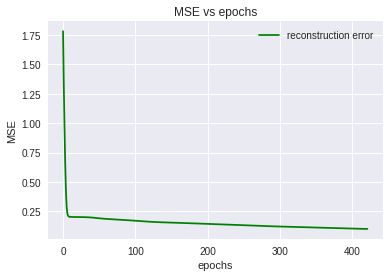

***********************************
number of epochs: 422
reconstruction error:  0.10195738336063022
***********************************
***********************************
bottle_neck_size :  24
***********************************
0 1.3513083980784628


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


100 1.1253761187797384
200 0.9637345370115219
300 0.8771683146603754
400 0.7975133473516742
500 0.7372124659248233
600 0.6838836639099903
700 0.6468458018026789
800 0.6110513936726705
900 0.5719255643293036


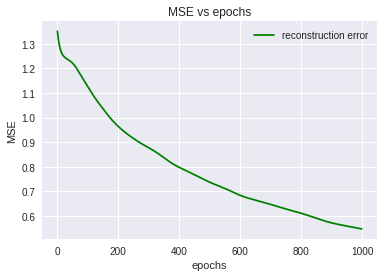

***********************************
number of epochs: 1000
reconstruction error:  0.5473502225554727
***********************************
***********************************
bottle_neck_size :  11
***********************************
0 0.7980840685577402
100 0.6689343161052117
200 0.5958735876906102
300 0.5308083621300937
400 0.4839915529431598
500 0.4383223132986442
600 0.40633497146465297
700 0.3865488811826916
800 0.35816903171320474
900 0.33916310362745733


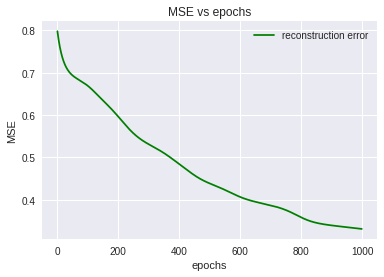

***********************************
number of epochs: 1000
reconstruction error:  0.33086454557084016
***********************************
***********************************
0 1.5999751134645335


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 1.096107460592514
100 0.9713053722067335
150 0.9310410071798636
200 0.9175860909275729
Reached threshold
number of epochs: 205
train error:  0.9171783250824558
test error:  1.1779142228618544


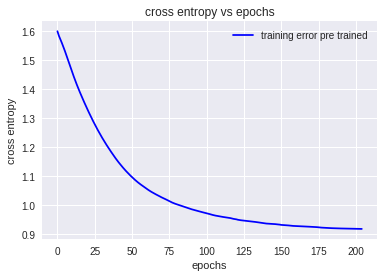

Train accuracy: 0.9962377727614747
Test accuracy: 0.7207207207207207


<Figure size 432x288 with 0 Axes>

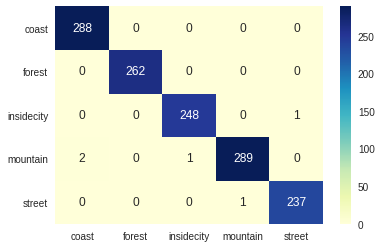

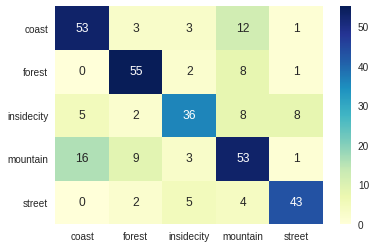

In [0]:
### Experiment ###
classifier,accuracy1,error_train1 = StackedAE_MLFFNN(x_train, y_train, x_test, y_test, 
                              learning_rate = 1e-4, max_epoch = 1000, 
                              error_threshold = 1e-4, bottle_neck_size = 292)

In [0]:
del classifier

In [0]:
################# Simple MLFFNN  #########################
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


    
def Simple_MLFFNN(x_train, y_train, x_test, y_test, learning_rate, max_epoch, error_threshold, bottle_neck_size): 
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  D_IN = x_train.shape[1]
  BOTTLENECK_SIZE = bottle_neck_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  AE1,bottle_neck1,AE2,bottle_neck2,AE3, bottle_neck3 = Stacked_AEs(bottle_neck_size = BOTTLENECK_SIZE)
  
  print('bottle_neck1 size:',bottle_neck1,'\nbottle_neck2 size:',bottle_neck2,'\nbottle_neck3 size:',bottle_neck3)
  
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 128, shuffle=False)
  
  classifier = torch.nn.Sequential(AE1.encoder,AE2.encoder,AE3.encoder,torch.nn.Linear(bottle_neck3, 5),
                                   torch.nn.Softmax())  
  del AE1,AE2,AE3
  classifier = classifier.to(device)
  
  '''def init_normal(m):
    if type(m) == torch.nn.Linear:
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.fill_(0.01)
      
  classifier.apply(init_normal)'''
  
  
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  accuracy = []
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader: 
    
    
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
     
    ##########
    y_pred_test = classifier(x_test_torch) 
    prediction_test = y_pred_test.cpu().detach().numpy()
    prediction_test = prediction_test.argmax(axis = 1)
    acc = accuracy_score(y_test, prediction_test)
    accuracy.append(acc.item())
    ###############
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break

  
  
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  test_error = loss_test.cpu().item()
  print('test error: ', test_error)
  
  
  plt.plot(error_train, color = 'b', label = 'training error random initialization')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc = accuracy_score(y_train, prediction_train)
  fig3 = plt.figure(3)
  print('Train accuracy:', acc)

  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)

  return classifier,accuracy,error_train

bottle_neck1 size: 292 
bottle_neck2 size: 143 
bottle_neck3 size: 70
0 1.6076076694943884


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 1.1167535906121195
100 1.0612479205631675
Reached threshold
number of epochs: 138
train error:  1.0321220525638994
test error:  1.3106311497521206


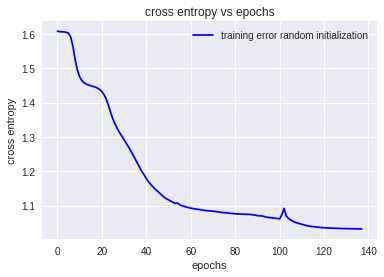

Train accuracy: 0.872836719337848
Test accuracy: 0.5885885885885885


<Figure size 432x288 with 0 Axes>

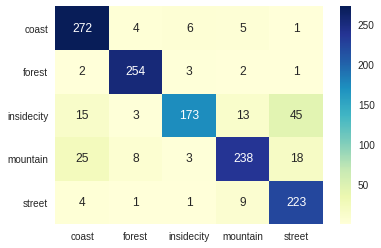

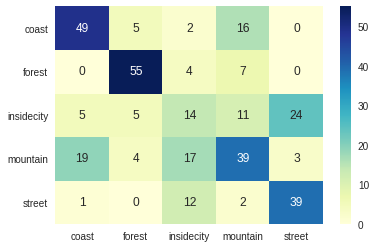

In [0]:
### Experiment #######
classifier,accuracy2,error_train2 = Simple_MLFFNN(x_train, y_train, x_test, y_test, 
                              learning_rate = 1e-4, max_epoch = 1000, 
                              error_threshold = 1e-4, bottle_neck_size = 292)

bottle_neck_size :  292
***********************************
0 1.7785955134069502
100 0.17622273634512162
200 0.143609646982616
300 0.11395193032307169
400 0.08960919293775316
500 0.07183583039345903
600 0.06039183127263541
700 0.05085539143845736
800 0.04263695210679013
900 0.03697420506437355


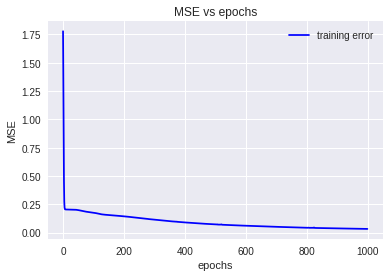

***********************************
number of epochs: 1000
training error:  0.03224263908062218
***********************************
***********************************
bottle_neck_size :  143
***********************************
0 0.6959338985936592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


100 0.33791446525342733
200 0.24071401271617293
300 0.18377263046742023
400 0.1458936018037698
500 0.11758439169096825
600 0.0955294894093537
700 0.07816205940496444
800 0.0639788696288247
900 0.051296265803120626


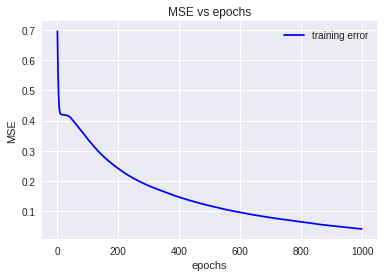

***********************************
number of epochs: 1000
training error:  0.040852747110716306
***********************************
***********************************
bottle_neck_size :  70
***********************************
0 0.6862513382958239
100 0.5164713724545007
200 0.4198149284210588
300 0.36206786292346194
400 0.323438375651392
500 0.29227916678162263
600 0.26621309987485003
700 0.24411653702415573
800 0.2261648886590026
900 0.20945151552331076


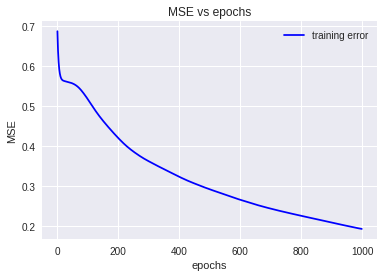

***********************************
number of epochs: 1000
training error:  0.1935534665805216
***********************************
***********************************
0 1.5957868621410192


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 0.9576105250279686
100 0.9435789223678346
150 0.9338107321788492
200 0.9452858480198517
250 0.9293180812243729
300 0.9272312949581649
350 0.9272070295791789
400 0.9271890024316605
450 0.927180207110709
500 0.9264948834724948
550 0.924406897893002
600 0.9230048324925747
650 0.9222434401775437
700 0.9215510383543201
750 0.9201072046069104
800 0.9194163390624365
850 0.9194163936940846
900 0.9193829641339462
950 0.9186618227773178
1000 0.9186482714755644
1050 0.918648370410138
1100 0.9186743842328714
1150 0.9186663406935398
1200 0.9186489409063888
1250 0.9186485338060468
1300 0.9186483049891613
1350 0.9186481382903185
1400 0.9186480040337958
1450 0.918647889635034
1500 0.9186477891031594
1550 0.9186476993737938
1600 0.918647618543137
1650 0.9186475446620832
1700 0.9186474641688757
1750 0.9178951117012079
1800 0.9178949916017831
1850 0.9178816344249412
1900 0.9178817964005955
1950 0.9178816181248801
2000 0.9178815394543907
2050 0.9178816236406305
2100 0.917881517586125
2150 0.91792869386

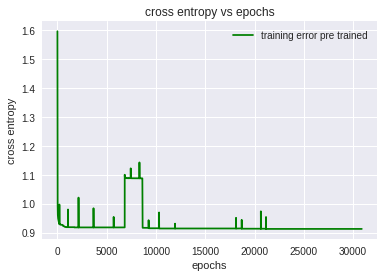

Train accuracy: 0.9917231000752446
Test accuracy: 0.6846846846846847


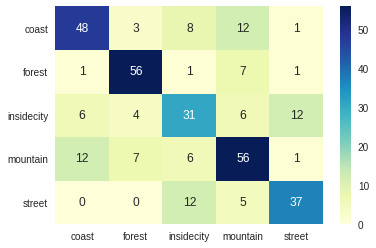

<Figure size 432x288 with 0 Axes>

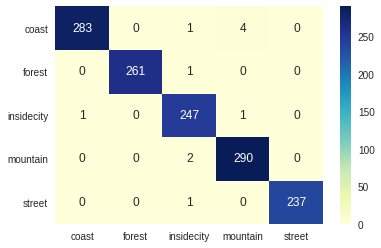

bottle_neck1 size: 292 
bottle_neck2 size: 143 
bottle_neck3 size: 70
0 1.608255916129901
50 1.0555610073288473
100 1.0342365270980507
150 1.023840429272103
200 1.018081070432458
250 1.0163366439035106
300 1.009041898702706
350 1.00842036758504
400 1.006621497242685
450 1.0054446126572487
500 1.0045402033471407
550 1.003955807698013
600 1.003808919125014
650 1.0037527951278047
700 1.000572279405084
750 0.9995493826273912
800 0.9995355738584087
850 0.9986849336880513
900 0.9986281637369807
950 0.9985730364387213
1000 0.9984734900635677
1050 0.9984517054123082
1100 0.998400496947158
1150 0.998345579099361
1200 0.9983424019470941
1250 0.9983312322613195
1300 0.9983274376188779
1350 0.9983302922795931
1400 0.9983207632284986
1450 0.9983153915691253
1500 1.0033648364851278
1550 1.0032493640856073
1600 1.0032107765044016
1650 1.002462687540519
1700 1.0155410642529568
1750 1.0054784732589837
1800 1.0031652772785942
1850 1.0031611268002638
1900 1.0031669468457698
1950 1.0031682584274124
2000 1

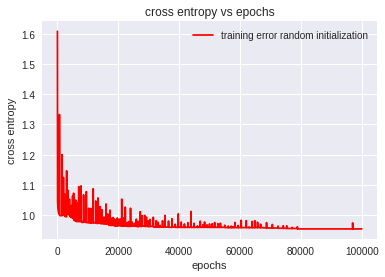

Train accuracy: 0.9480812641083521
Test accuracy: 0.6126126126126126


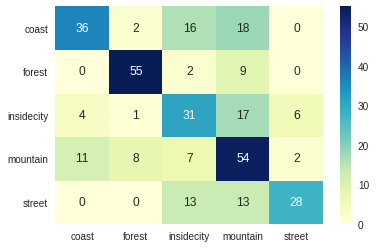

<Figure size 432x288 with 0 Axes>

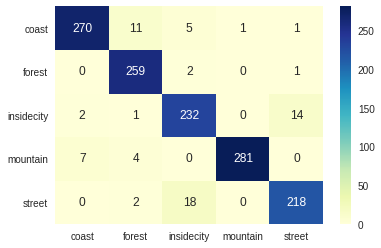

In [0]:
############### Final Result ##########################
'''classifier, accuracy_pre_trained, loss_pre_trained = StackedAE_MLFFNN(x_train, y_train, x_test, y_test, 
                              learning_rate = 1e-4, max_epoch = 100000, 
                              error_threshold = -500, bottle_neck_size = 292)

classifier,accuracy_random, loss_random = Simple_MLFFNN(x_train, y_train, x_test, y_test, 
                              learning_rate = 1e-4, max_epoch = 100000, 
                              error_threshold = -500, bottle_neck_size = 292)'''


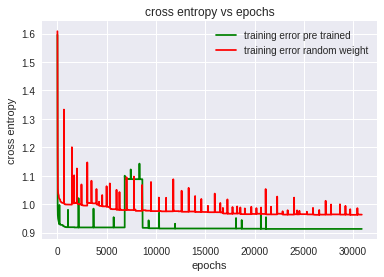

In [0]:
plt.plot(loss_pre_trained, color = 'g', label = 'training error pre trained')
plt.plot(loss_random[0:len(loss_pre_trained)], color = 'r', label = 'training error random weight')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('cross entropy')
plt.title('cross entropy vs epochs')
plt.show()

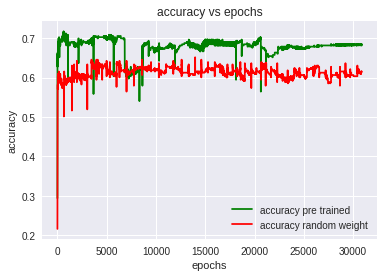

In [0]:
plt.plot(accuracy_pre_trained,  color = 'g', label = 'accuracy pre trained')
plt.plot(accuracy_random[0:len(accuracy_pre_trained)], color = 'r', label = 'accuracy random weight')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy vs epochs')
plt.show()